#Let's get deep into Classification Tasks

Connect to Google Drive

In [13]:
#Mount the google drive connection to our dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Load the dataset

In [14]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/AI/Project 4/dataset/apple_quality.csv')

In [15]:
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


Process the df

In [16]:
df.drop(df.tail(1).index, inplace=True)

In [17]:
df.drop("A_id", axis=1, inplace=True)

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [19]:
column_transformer = ColumnTransformer([
    ('quality_encoder', OneHotEncoder(), ['Quality']),
], remainder='passthrough')

In [20]:
pipeline = Pipeline([
    ('preprocessing', column_transformer),
])

In [21]:
df_encoded = pipeline.fit_transform(df)

In [22]:
import pandas as pd

non_encoded_features = list(df.columns[df.columns != 'Quality'])

encoder = pipeline.named_steps['preprocessing'].named_transformers_['quality_encoder']
encoded_feature_names = encoder.get_feature_names_out(['Quality'])

df_encoded_with_names = pd.DataFrame(df_encoded, columns=list(encoded_feature_names) + non_encoded_features)

print(df_encoded_with_names.head())

  Quality_bad Quality_good      Size    Weight Sweetness Crunchiness  \
0         0.0          1.0 -3.970049 -2.512336   5.34633   -1.012009   
1         0.0          1.0 -1.195217 -2.839257  3.664059    1.588232   
2         1.0          0.0 -0.292024 -1.351282 -1.738429   -0.342616   
3         0.0          1.0 -0.657196 -2.271627  1.324874   -0.097875   
4         0.0          1.0  1.364217 -1.296612 -0.384658   -0.553006   

  Juiciness  Ripeness       Acidity  
0    1.8449   0.32984  -0.491590483  
1  0.853286   0.86753  -0.722809367  
2  2.838636 -0.038033   2.621636473  
3   3.63797 -3.413761   0.790723217  
4  3.030874 -1.303849   0.501984036  


Stochastich Gradient Descent (SGD)

In [55]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import numpy as np

In [56]:
X = df_encoded_with_names.drop(columns=['Quality_good'])
y = df_encoded_with_names['Quality_good']

Solved Data Type problem: https://stackoverflow.com/questions/74081015/valueerror-supported-target-types-are-binary-multiclass-got-unknown

In [57]:
y = np.array(y, dtype=float)

In [58]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [59]:
sgd_clf = SGDClassifier(random_state=42)

Cross-Validation with StratifiedKFold

In [60]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(sgd_clf, X_train, y_train, cv=skf, scoring='accuracy')

In [62]:
print("Cross-Validation Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Mean Accuracy: 0.99875


In [61]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

Loss Function => Accuracy

In [63]:
y_val_pred = sgd_clf.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Set Accuracy:", accuracy_val)

y_test_pred = sgd_clf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test Set Accuracy:", accuracy_test)

Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


Confusion Matrix (With precision, recall and F1)

In [65]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

In [66]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=skf)

In [74]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_train, y_train_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1195    3]
 [   0 1202]]


Precision, Recall and F1

In [68]:
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9975103734439834
Recall: 1.0
F1 Score: 0.9987536352305775


In [69]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=skf, method="decision_function")

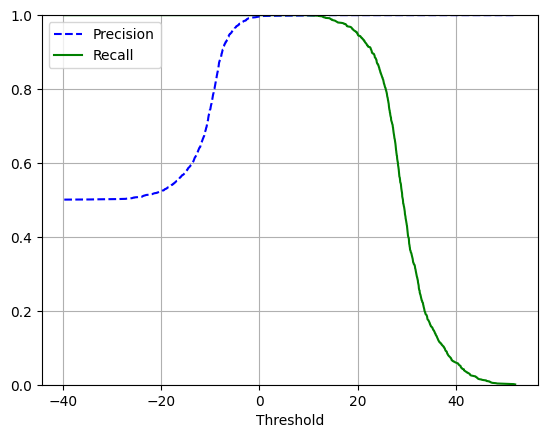

In [70]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.grid(True)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Precision/Recall Tradeoff => decision_function() for managing threshold and achieve better results

Raising the threshold decreases recall and increase precision (In General)

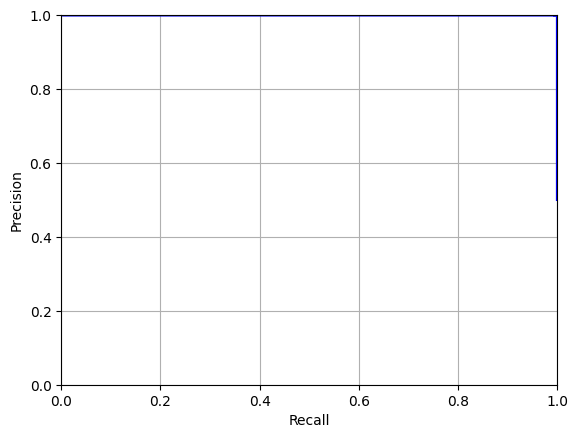

In [75]:
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

ROC

Tradeoff => Recall and False Positives (FPR)

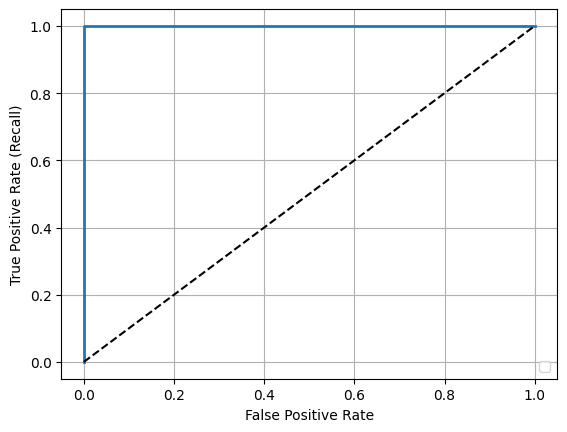

In [76]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid(True)
    plt.legend(loc="lower right")

plot_roc_curve(fpr, tpr)
plt.show()

AUC must be > 0.5 in order to be a good clf

In [77]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_train, y_scores)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9999951388753857




*   PR is better for rare positive class or caring more about false positives than false negatives
*   ROC is otherwhise



Other clfs, such as RandomForestClassifier, don't have decision_function. Instead, they have "predict_proba"